In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import proxy_finder

In [2]:
#agonist = "ADP_META"
agonists = ["ADP_META","CRP","PAR1","PAR4"]

pfcs = []
for ago in agonists:
    pfc = pd.read_csv("pfc_results/%s.tsv" % ago,sep="\t",usecols=["CHR","POS","RSID","MLOG10P","AAF"])
    #pfc = pfc.loc[pfc.AAF > 0.01]
    #pfc = pfc.sort_values("MLOG10P",ascending=False)
    pfc["agonist"] = ago
    pfcs.append(pfc)
pfc = pd.concat(pfcs,axis=0)
pfc_best = pfc.sort_values("MLOG10P").groupby(["CHR","POS"])[["MLOG10P","RSID"]].last().reset_index()
pfc_snps = pfc_best[["CHR","POS"]].astype(str).agg("_".join,axis=1).tolist()
pfc.head()

,RSID,CHR,POS,AAF,MLOG10P,agonist
0,rs3131972,1,752721,0.83720,0.03656,ADP_META
1,rs3115860,1,753405,0.86180,0.04916,ADP_META
2,rs2073813,1,753541,0.13770,0.04938,ADP_META
3,rs12184312,1,754063,0.03512,0.32430,ADP_META
4,rs12184325,1,754105,0.03496,0.33750,ADP_META


In [3]:
st4 = pd.read_excel("INTERVAL_Astle_results/1-s2.0-S0092867416314635-mmc4.xlsx",skiprows=2)
st4 = st4.loc[st4["Associated Blood Index"].isin(["PLT#","MPV","PCT","PDW"])]
st4 = st4.replace({"PLT#":"PLT"})

In [4]:
large_files = glob.glob("INTERVAL_Astle_results/*.tsv")
dfs = []
for f in large_files:
    pheno = f.split("/")[-1].split("_")[0].upper()
    df = pd.read_csv(f,sep="\t",usecols=["ID","CHR","BP","MLOG10P_INT"]).rename(columns={"MLOG10P_INT":"MLOG10P"})
    df["pheno"] = pheno
    dfs.append(df)
ldf = pd.concat(dfs,ignore_index=True)

In [5]:
hippo_results = pd.read_csv("ST3_Verdier2023.csv")
hippo_results.loc[(hippo_results["Chr"] == 6) & (hippo_results["Position"] == 31322694),"Position"] = 31323065
hippo_results.loc[(hippo_results["Chr"] == 15) & (hippo_results["Position"] == 65160392),"Position"] = 65164845
pfc_best_hippo = pfc_best.merge(hippo_results[["Chr","Position"]],left_on=["CHR","POS"],right_on=["Chr","Position"])
p_values_hippolyte = pfc_best_hippo.MLOG10P.values
quantiles = np.linspace(0,1,p_values_hippolyte.shape[0],endpoint=True)
q_hippolyte = np.quantile(p_values_hippolyte,quantiles)
pfc_best_hippo.to_csv("PFC_GWAS_Verdier_SNPs.csv")

In [6]:
def cdf(x):
    N = x.shape[0]
    return np.sort(x), np.arange(N+1)[1:]/float(N)

In [7]:
snps_proxy_recap = pd.DataFrame(columns=["TOTAL SNPs in Astle et al.","Found directly in PFC","Found proxy in PFC","No proxy found"])

20 missing rsIDs over 88
Loading pre-existing proxies
12 matched IDs
9 missing rsIDs over 59
Loading pre-existing proxies
5 matched IDs
7 missing rsIDs over 53
Loading pre-existing proxies
6 matched IDs
16 missing rsIDs over 79
Loading pre-existing proxies
8 matched IDs


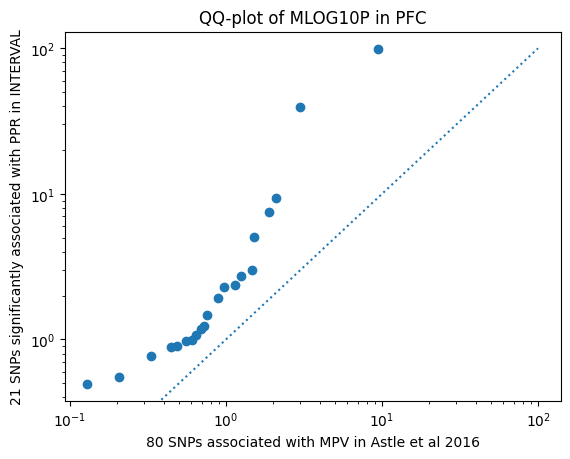

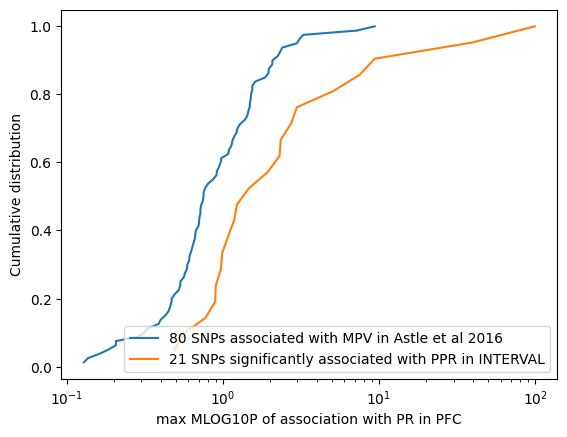

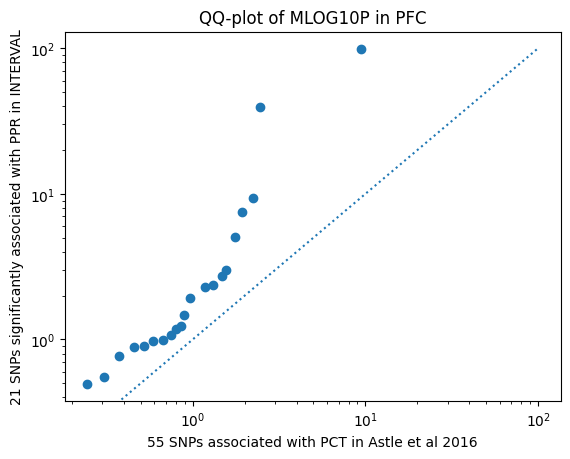

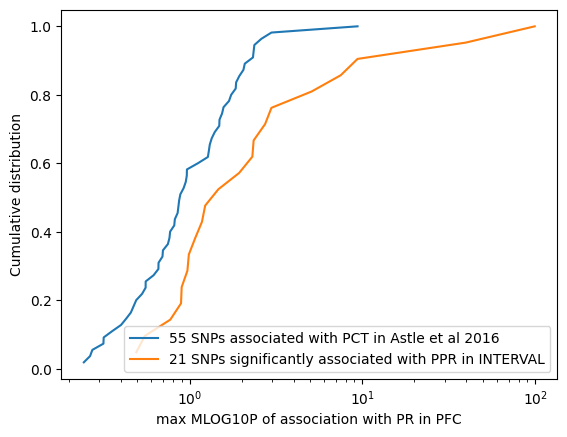

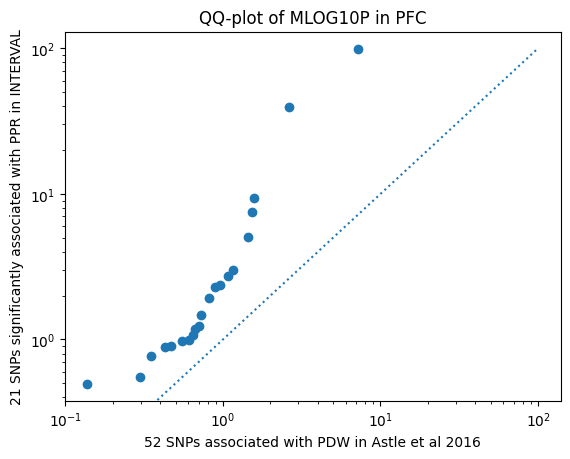

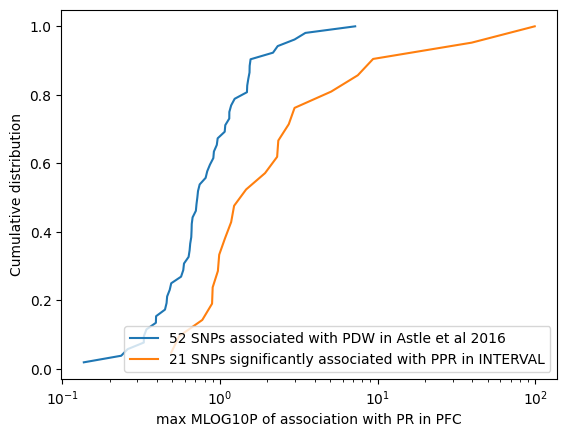

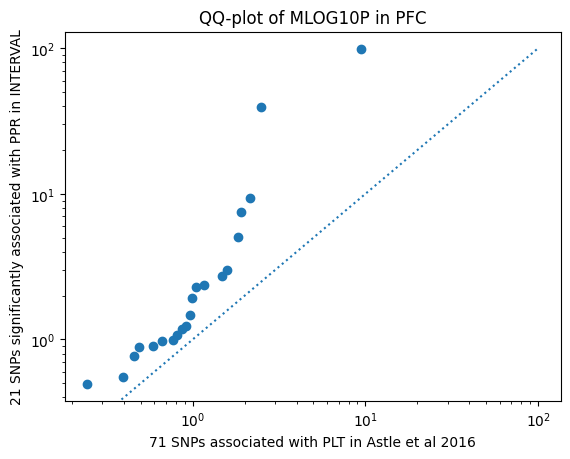

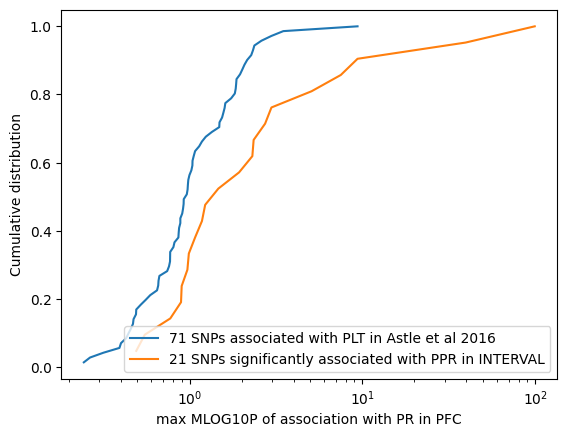

In [11]:
plot=True

for trait,st4_trait in st4.groupby("Associated Blood Index"):
    best = ldf.loc[ldf.pheno == trait]
    best = best.loc[best.MLOG10P > 8]
    best_st4 = best.merge(
        st4_trait[["Chr (GRCh37)","BP (GRCh37)"]],
        left_on=["CHR","BP"],
        right_on=["Chr (GRCh37)","BP (GRCh37)"],
        how="inner")
    st4_snps = best_st4[["CHR","BP"]].astype(str).agg("_".join,axis=1).unique().tolist()
    best_st4["SNP_ID"] = st4_snps
    missing = set(st4_snps).difference(pfc_snps)
    
    missing_rsIDs = best_st4.loc[best_st4.SNP_ID.isin(missing),"ID"].unique().tolist()
    assert len(missing_rsIDs) == len(missing)
    valid_coords = ("chr" + pfc_best["CHR"].astype(str) + ":" + pfc_best["POS"].astype(str)).unique().tolist()
    
    print("%d missing rsIDs over %d" % (len(missing_rsIDs),len(st4_snps)))
    snps_proxy_recap.loc[trait,"TOTAL SNPs in Astle et al."] = len(st4_snps)
    snps_proxy_recap.loc[trait,"Found directly in PFC"] = len(st4_snps) - len(missing_rsIDs)
    
    proxies = proxy_finder.find_proxies(
        missing_rsIDs,
        proxies_json_path="interval_proxies_r2.json",
        valid_coords = valid_coords,
        LDLink_API_token = "14ad36e8238c",
    )
    
    matched_rsIDs = [m for m in missing_rsIDs if "error" not in proxies[m]]
    print("%d matched IDs" % len(matched_rsIDs))
    snps_proxy_recap.loc[trait,"Found proxy in PFC"] = len(matched_rsIDs)
    snps_proxy_recap.loc[trait,"No proxy found"] = len(missing_rsIDs) - len(matched_rsIDs)
    
    for m in matched_rsIDs:
        best_st4.loc[best_st4.ID == m,"CHR"] = int(proxies[m]["coords"].split(":")[0][3:])
        best_st4.loc[best_st4.ID == m,"BP" ] = int(proxies[m]["coords"].split(":")[1])
        
    pfc_best_lf = pfc_best.merge(best_st4[["CHR","BP"]],left_on=["CHR","POS"],right_on=["CHR","BP"],how="inner")
    pfc_best_lf.to_csv("PFC_GWAS_INTERVAL_%s_SNPs.csv" % trait)
    p_values_astle = pfc_best_lf["MLOG10P"].values
    
    q_astle = np.quantile(p_values_astle,quantiles)
    
    if plot:
        plt.figure()
        plt.scatter(q_astle,q_hippolyte)
        label_a = "%d SNPs associated with %s in Astle et al 2016" % (len(p_values_astle),trait)
        label_h = "%d SNPs significantly associated with PPR in INTERVAL" % (len(p_values_hippolyte))
        plt.xlabel(label_a)
        plt.ylabel(label_h)
        plt.plot([0,100],[0,100],ls=":")
        plt.yscale("log")
        plt.xscale("log")
        plt.title("QQ-plot of MLOG10P in PFC");
        plt.savefig("%s_qq_plot.pdf" % trait)
        
        plt.figure()
        x_h, cdf_h = cdf(p_values_hippolyte)
        x_a, cdf_a = cdf(p_values_astle)
        plt.plot(x_a,cdf_a,label=label_a)
        plt.plot(x_h,cdf_h,label=label_h)
        plt.legend()
        plt.xscale("log")
        plt.xlabel("max MLOG10P of association with PR in PFC")
        plt.ylabel("Cumulative distribution")
        plt.savefig("%s_cdf_plot.pdf" % trait)

In [10]:
snps_proxy_recap

,TOTAL SNPs in Astle et al.,Found directly in PFC,Found proxy in PFC,No proxy found
MPV,88,68,12,8
PCT,59,50,5,4
PDW,53,46,6,1
PLT,79,63,8,8


In [15]:
proxies_df = pd.DataFrame.from_dict(proxies,orient="index").reset_index().rename(columns={"index":"Missing SNP","rsID":"proxy rsID","coords":"proxy coords"})

In [16]:
proxies_df.to_csv("proxies_df.csv")